Usando dispositivo: cuda
ENTRENAMIENTO DEL GAN - 30 ÉPOCAS
Epoch [1/30] - Loss_D: 0.1214, Loss_G: 4.5353
Epoch [5/30] - Loss_D: 0.2642, Loss_G: 3.5478
Epoch [10/30] - Loss_D: 0.0557, Loss_G: 7.8873
Epoch [15/30] - Loss_D: 0.1203, Loss_G: 4.4913
Epoch [20/30] - Loss_D: 0.1090, Loss_G: 5.3280
Epoch [25/30] - Loss_D: 0.1102, Loss_G: 4.6224
Epoch [30/30] - Loss_D: 0.1544, Loss_G: 4.1762
ENTRENAMIENTO COMPLETADO

Guardando modelo...
✓ Modelo guardado en 'gan_model.pth'

Generando gráfica de pérdidas...


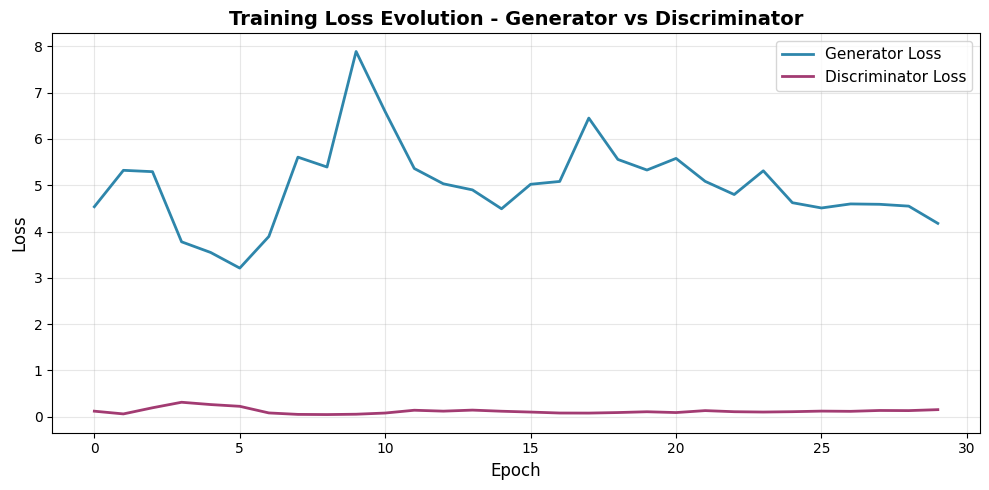


Generando imágenes de muestra...


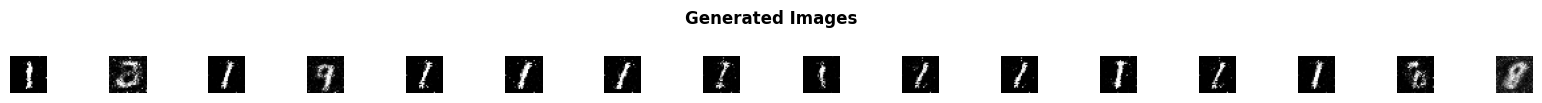


PARTE 1 COMPLETADA
Ahora ejecuta la PARTE 2 para calcular métricas


In [1]:
# =====================================================
# PARTE 1: ENTRENAMIENTO DEL GAN
# Ejecuta esta parte primero, luego continúa con PARTE 2
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# =====================================================
# DATA LOADING AND PREPROCESSING
# =====================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

# =====================================================
# GENERATOR MODEL
# =====================================================
class Generator(nn.Module):
    """
    Generador: Red neuronal que convierte ruido aleatorio en imágenes falsas
    """
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

# =====================================================
# DISCRIMINATOR MODEL
# =====================================================
class Discriminator(nn.Module):
    """
    Discriminador: Red neuronal que clasifica imágenes como reales o falsas
    """
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# =====================================================
# TRAINING WITH LOSS TRACKING
# =====================================================
z_dim = 100
lr = 0.0002

generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

# REDUCIR ÉPOCAS PARA EVITAR TIMEOUT
# 50 épocas pueden causar que el kernel se reinicie por timeout
# Reducimos a 30 para entrenamiento más rápido
num_epochs = 30

gen_losses = []
disc_losses = []

print("="*70)
print(f"ENTRENAMIENTO DEL GAN - {num_epochs} ÉPOCAS")
print("="*70)

for epoch in range(num_epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    num_batches = 0

    for real, _ in dataloader:
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        label_real = torch.ones(batch_size, 1, device=device)
        label_fake = torch.zeros(batch_size, 1, device=device)

        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)

        loss_disc_real = criterion(discriminator(real), label_real)
        loss_disc_fake = criterion(discriminator(fake.detach()), label_fake)
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        optimizer_disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        output = discriminator(fake)
        loss_gen = criterion(output, label_real)

        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        epoch_gen_loss += loss_gen.item()
        epoch_disc_loss += loss_disc.item()
        num_batches += 1

    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches

    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)

    # Mostrar progreso cada 5 épocas para reducir output
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss_D: {avg_disc_loss:.4f}, Loss_G: {avg_gen_loss:.4f}")

print("="*70)
print("ENTRENAMIENTO COMPLETADO")
print("="*70)

# =====================================================
# GUARDAR MODELO
# =====================================================
print("\nGuardando modelo...")
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'gen_losses': gen_losses,
    'disc_losses': disc_losses,
    'z_dim': z_dim,
    'num_epochs': num_epochs
}, 'gan_model.pth')
print("✓ Modelo guardado en 'gan_model.pth'")

# =====================================================
# VISUALIZAR EVOLUCIÓN DE PÉRDIDAS
# =====================================================
print("\nGenerando gráfica de pérdidas...")

plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss', linewidth=2, color='#2E86AB')
plt.plot(disc_losses, label='Discriminator Loss', linewidth=2, color='#A23B72')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Evolution - Generator vs Discriminator', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================
# SAMPLING AND VISUALIZATION
# =====================================================
print("\nGenerando imágenes de muestra...")

n_images = 16
noise = torch.randn(n_images, z_dim, device=device)

with torch.no_grad():
    gen_imgs = generator(noise).cpu().numpy()

gen_imgs = gen_imgs.reshape(n_images, 28, 28)

fig, axes = plt.subplots(1, n_images, figsize=(n_images, 1))
for img, ax in zip(gen_imgs, axes):
    ax.imshow((img + 1) / 2, cmap='gray')
    ax.axis('off')
plt.suptitle('Generated Images', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PARTE 1 COMPLETADA")
print("Ahora ejecuta la PARTE 2 para calcular métricas")
print("="*70)


In [2]:
# =====================================================
# PARTE 2: CÁLCULO DE MÉTRICAS
# Ejecuta esta parte DESPUÉS de completar la PARTE 1
# =====================================================

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import subprocess
import sys
import gc

# Limpiar memoria antes de empezar
# gc.collect() fuerza la recolección de basura
# torch.cuda.empty_cache() limpia la caché de GPU
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# =====================================================
# DEFINIR CLASES DEL MODELO
# =====================================================
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# =====================================================
# CARGAR MODELO GUARDADO
# =====================================================
print("\n" + "="*70)
print("CARGANDO MODELO GUARDADO")
print("="*70)

checkpoint = torch.load('gan_model.pth', map_location=device)

z_dim = checkpoint['z_dim']
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

gen_losses = checkpoint['gen_losses']
disc_losses = checkpoint['disc_losses']
num_epochs = checkpoint['num_epochs']

generator.eval()
discriminator.eval()

print(f"✓ Modelo cargado correctamente")
print(f"  Entrenado por {num_epochs} épocas")
print(f"  Pérdida final - Generator: {gen_losses[-1]:.4f}, Discriminator: {disc_losses[-1]:.4f}")

# =====================================================
# INSTALAR DEPENDENCIAS
# =====================================================
print("\n" + "="*70)
print("INSTALANDO DEPENDENCIAS PARA MÉTRICAS")
print("="*70)

def check_module(module_name):
    try:
        __import__(module_name)
        return True
    except ImportError:
        return False

def install_package(package_name):
    print(f"Instalando {package_name}...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package_name])
    print(f"✓ {package_name} instalado")

# Instalar paquetes necesarios
required_packages = {
    'torchmetrics': 'torchmetrics',
    'torch_fidelity': 'torch-fidelity'
}

for module_name, package_name in required_packages.items():
    if not check_module(module_name):
        install_package(package_name)
    else:
        print(f"✓ {package_name} ya está instalado")

# Importar dinámicamente
import importlib
InceptionScore = importlib.import_module('torchmetrics.image.inception').InceptionScore
FrechetInceptionDistance = importlib.import_module('torchmetrics.image.fid').FrechetInceptionDistance

print("✓ Módulos importados correctamente")

# =====================================================
# PREPARAR IMÁGENES - VERSIÓN OPTIMIZADA
# =====================================================
print("\n" + "="*70)
print("GENERANDO IMÁGENES PARA EVALUACIÓN")
print("="*70)

# REDUCIR NÚMERO DE MUESTRAS PARA EVITAR PROBLEMAS DE MEMORIA
# 1000 muestras pueden causar OOM (Out Of Memory)
# Usamos 500 que es suficiente para métricas confiables
num_samples = 500
print(f"Número de muestras: {num_samples}")

# Generar en batches pequeños para evitar OOM
batch_size = 100
fake_images_list = []

print("Generando imágenes falsas en batches...")
for i in range(0, num_samples, batch_size):
    current_batch_size = min(batch_size, num_samples - i)
    noise = torch.randn(current_batch_size, z_dim, device=device)

    with torch.no_grad():
        fake_batch = generator(noise).cpu()

    fake_images_list.append(fake_batch)

    # Limpiar memoria después de cada batch
    del noise, fake_batch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"  Generadas {i + current_batch_size}/{num_samples} imágenes")

# Concatenar todos los batches
fake_images = torch.cat(fake_images_list, dim=0)
del fake_images_list
gc.collect()

fake_images = fake_images.view(-1, 1, 28, 28)

# Procesar imágenes
print("Procesando imágenes generadas...")
fake_images_rgb = fake_images.repeat(1, 3, 1, 1)
fake_images_rgb = F.interpolate(fake_images_rgb, size=(299, 299), mode='bilinear', align_corners=False)
fake_images_rgb = (fake_images_rgb + 1) / 2
fake_images_rgb = torch.clamp(fake_images_rgb, 0, 1)
fake_images_rgb = (fake_images_rgb * 255).byte()

# Limpiar memoria
del fake_images
gc.collect()

# =====================================================
# PREPARAR IMÁGENES REALES
# =====================================================
print("Cargando imágenes reales...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

real_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
real_subset = Subset(real_dataset, range(num_samples))
real_loader = DataLoader(real_subset, batch_size=num_samples, shuffle=False)

real_images, _ = next(iter(real_loader))

# Procesar imágenes reales
real_images_rgb = real_images.repeat(1, 3, 1, 1)
real_images_rgb = F.interpolate(real_images_rgb, size=(299, 299), mode='bilinear', align_corners=False)
real_images_rgb = (real_images_rgb + 1) / 2
real_images_rgb = torch.clamp(real_images_rgb, 0, 1)
real_images_rgb = (real_images_rgb * 255).byte()

# Limpiar memoria
del real_images
gc.collect()

# =====================================================
# CALCULAR MÉTRICAS
# =====================================================
print("\n" + "="*70)
print("CALCULANDO MÉTRICAS")
print("="*70)

# Inception Score
print("\nCalculando Inception Score...")
try:
    is_metric = InceptionScore(normalize=True)
    is_score, is_std = is_metric(fake_images_rgb)
    print(f"✓ Inception Score: {is_score.item():.4f} ± {is_std.item():.4f}")
except Exception as e:
    print(f"✗ Error calculando IS: {e}")
    is_score = torch.tensor(0.0)
    is_std = torch.tensor(0.0)

# Limpiar memoria antes de FID
del is_metric
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# FID
print("\nCalculando Fréchet Inception Distance...")
try:
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True)
    fid_metric.update(real_images_rgb, real=True)
    fid_metric.update(fake_images_rgb, real=False)
    fid_score = fid_metric.compute()
    print(f"✓ FID Score: {fid_score.item():.4f}")
except Exception as e:
    print(f"✗ Error calculando FID: {e}")
    fid_score = torch.tensor(0.0)

# =====================================================
# RESUMEN FINAL
# =====================================================
print("\n" + "="*70)
print("RESUMEN COMPLETO DEL MODELO GAN")
print("="*70)

print(f"\n📊 MÉTRICAS DE EVALUACIÓN:")
print(f"   • Inception Score (IS): {is_score.item():.4f} ± {is_std.item():.4f}")
print(f"   • Fréchet Inception Distance (FID): {fid_score.item():.4f}")

print(f"\n📈 INFORMACIÓN DE ENTRENAMIENTO:")
print(f"   • Total de épocas: {num_epochs}")
print(f"   • Pérdida final del Generador: {gen_losses[-1]:.4f}")
print(f"   • Pérdida final del Discriminador: {disc_losses[-1]:.4f}")
print(f"   • Learning rate: 0.0002")
print(f"   • Dimensión del espacio latente: {z_dim}")
print(f"   • Muestras evaluadas: {num_samples}")

print(f"\n💡 INTERPRETACIÓN:")
if is_score.item() > 0:
    if is_score.item() > 5:
        print(f"   ✓ IS = {is_score.item():.2f} > 5: Excelente calidad")
    elif is_score.item() > 2:
        print(f"   ~ IS = {is_score.item():.2f} (2-5): Calidad moderada")
    else:
        print(f"   ✗ IS = {is_score.item():.2f} < 2: Calidad baja")

if fid_score.item() > 0:
    if fid_score.item() < 50:
        print(f"   ✓ FID = {fid_score.item():.2f} < 50: Alta similitud")
    elif fid_score.item() < 100:
        print(f"   ~ FID = {fid_score.item():.2f} (50-100): Similitud moderada")
    else:
        print(f"   ✗ FID = {fid_score.item():.2f} > 100: Baja similitud")

print("="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)


Usando dispositivo: cuda

CARGANDO MODELO GUARDADO
✓ Modelo cargado correctamente
  Entrenado por 30 épocas
  Pérdida final - Generator: 4.1762, Discriminator: 0.1544

INSTALANDO DEPENDENCIAS PARA MÉTRICAS
✓ torchmetrics ya está instalado
✓ torch-fidelity ya está instalado
✓ Módulos importados correctamente

GENERANDO IMÁGENES PARA EVALUACIÓN
Número de muestras: 500
Generando imágenes falsas en batches...
  Generadas 100/500 imágenes
  Generadas 200/500 imágenes
  Generadas 300/500 imágenes
  Generadas 400/500 imágenes
  Generadas 500/500 imágenes
Procesando imágenes generadas...
Cargando imágenes reales...

CALCULANDO MÉTRICAS

Calculando Inception Score...


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


✓ Inception Score: 2.6198 ± 0.1896

Calculando Fréchet Inception Distance...
✓ FID Score: 271.0880

RESUMEN COMPLETO DEL MODELO GAN

📊 MÉTRICAS DE EVALUACIÓN:
   • Inception Score (IS): 2.6198 ± 0.1896
   • Fréchet Inception Distance (FID): 271.0880

📈 INFORMACIÓN DE ENTRENAMIENTO:
   • Total de épocas: 30
   • Pérdida final del Generador: 4.1762
   • Pérdida final del Discriminador: 0.1544
   • Learning rate: 0.0002
   • Dimensión del espacio latente: 100
   • Muestras evaluadas: 500

💡 INTERPRETACIÓN:
   ~ IS = 2.62 (2-5): Calidad moderada
   ✗ FID = 271.09 > 100: Baja similitud
ANÁLISIS COMPLETADO
